In [235]:
%matplotlib inline

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

In [236]:
df = pd.read_stata('../../../HCMST 2017 fresh sample for public sharing draft v1.1.dta')

In [237]:
chosen_cols = [
    'time_from_met_to_rel',  # numeryczna - czas (w latach), który upłynął od poznania do wejścia w związek
    'time_from_rel_to_cohab', # numeryczna - czas (w latach), który upłynął od wejścia w związek do zamieszkania razem
    'Q25',  # jakościowa - czy uczęszczałeś z partnerem do tej samej szkoły średniej
    'Q12', # jakościowa - jak partner opisuje swoje poglądy polityczne
    'S1',  # output
]

df[chosen_cols].head()

,time_from_met_to_rel,time_from_rel_to_cohab,Q25,Q12,S1
0,0.000000,NaN,NaN,NaN,"No, I am not Married"
1,12.250000,0.500000,Different High School,Leans Republican,"Yes, I am Married"
2,0.416748,0.083252,Different High School,Leans Democrat,"Yes, I am Married"
3,1.083252,NaN,NaN,NaN,"No, I am not Married"
4,0.083252,0.833374,Different High School,Strong Democrat,"Yes, I am Married"


In [238]:
# kilka parametrów danych
print(df[chosen_cols].count())  # liczba niepustych wartości w każdej kolumnie 
print('=' * 30)
print('before drop:', len(df[chosen_cols]))
print('after drop:', len(df[chosen_cols].dropna()))  # liczba wierszy przed i po usunięciu niekompletnych wierszy

cleaner_df = df[chosen_cols].dropna()
cleaner_df['S1'] = cleaner_df['S1'].apply(lambda x: 1 if x == 'Yes, I am Married' else 0)
cleaner_df['S1'] = cleaner_df['S1'].astype('float')  # przekształcenie kolumny wynikowej do postaci 0/1
final_df = cleaner_df
final_df.head()

time_from_met_to_rel      3263
time_from_rel_to_cohab    2578
Q25                       2856
Q12                       2856
S1                        3510
dtype: int64
before drop: 3510
after drop: 2354


,time_from_met_to_rel,time_from_rel_to_cohab,Q25,Q12,S1
1,12.250000,0.500000,Different High School,Leans Republican,1.0
2,0.416748,0.083252,Different High School,Leans Democrat,1.0
4,0.083252,0.833374,Different High School,Strong Democrat,1.0
5,0.500000,0.000000,Different High School,Undecided/Independent/Other,1.0
6,0.250000,2.583374,Different High School,Leans Republican,1.0


In [239]:
X = final_df.loc[:, final_df.columns != 'S1']
y = final_df.loc[:, 'S1']

X_train = pd.get_dummies(X).sort_index(axis=1)
y_train = y

In [240]:
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline


columns_dict = {
    'time_from_met_to_rel': ['numeric', None],
    'time_from_rel_to_cohab': ['numeric', None],
    'Q25': ['categorical', ['Different High School', 'Same High School', 'Refused']],
    'Q12': ['categorical', ['Leans Republican', 'Leans Democrat', 'Strong Democrat',
                            'Undecided/Independent/Other', 'Not Strong Democrat', 
                            'Strong Republican', 'Not Strong Republican', 'Refused']]
}

class GetDummies(TransformerMixin):
    
    def __init__(self, columns):
        self.num_columns = [col for col in columns if columns[col][0] == 'numeric']
        self.cat_columns = [[col, columns[col][1]] for col in columns if columns[col][0] == 'categorical']
        self.col_names = self.num_columns + [f"{col}_{cat}" for col, categories in self.cat_columns 
                                                            for cat in categories]

    def fit(self, X, y=None, **kwargs):
        return self

    def transform(self, X, y=None, **kwargs):
        X_trans = X[self.num_columns]
        for col_name, categories in self.cat_columns:
            for cat in categories:
                X_trans.insert(len(X_trans.columns), f"{col_name}_{cat}", np.where(X[col_name] == cat, 1, 0))
                
        return X_trans

In [241]:
from sklearn.metrics import accuracy_score

forest_pipeline = Pipeline([('get_dummies', GetDummies(columns_dict))])

X_forest = forest_pipeline.fit_transform(X)
y_forest = y

forest = RandomForestClassifier(**
                                {'max_depth': 9,
                                 'max_features': 3,
                                 'min_samples_split': 2,
                                 'n_estimators': 500
                                },
                                n_jobs=-1)

forest.fit(X_forest, y_forest)
accuracy_score(y_forest, forest.predict(X_forest))

0.8449447748513169

In [260]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures


log_reg_pipeline = Pipeline([
    ('get_dummies', GetDummies(columns_dict)),
    ('polynomial_fetures', PolynomialFeatures(2)),
])

X_log_reg = log_reg_pipeline.fit_transform(X, y)
y_log_reg = y

log_reg = LogisticRegression()

log_reg.fit(X_log_reg, y_log_reg)
accuracy_score(y_log_reg, log_reg.predict(X_log_reg))

0.8300764655904843

In [261]:
def shuffle(X, col):
    X_shuffled = X.copy()
    X_shuffled[col] = np.random.permutation(X[col].values)
    return X_shuffled

In [270]:
forest_base = accuracy_score(y_forest, forest.predict(X_forest))
log_red_base = accuracy_score(y_log_reg, log_reg.predict(X_log_reg))

forest_changes_acc = {}
log_reg_changes_acc = {}

for col in X.columns:
    X_shuffle = shuffle(X, col)
    Xf_shuff = forest_pipeline.fit_transform(X_shuffle)
    Xl_shuff = log_reg_pipeline.fit_transform(X_shuffle)
    forest_changes_acc[col] = (forest_base - accuracy_score(y_forest, forest.predict(Xf_shuff))) * 100
    log_reg_changes_acc[col] = (log_red_base - accuracy_score(y_log_reg, log_reg.predict(Xl_shuff))) * 100

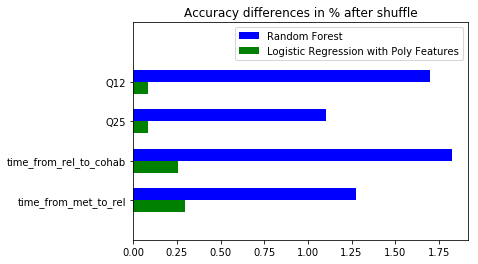

In [271]:
import matplotlib.pyplot as plt

plt.barh(np.arange(0, len(forest_changes_acc)) + 0.15, list(forest_changes_acc.values()), height=0.3, color='b', align='center')
plt.barh(np.arange(len(log_reg_changes_acc)) - 0.15, list(log_reg_changes_acc.values()), height=0.3, color='g', align='center')
plt.yticks(range(len(forest_changes_acc)), forest_changes_acc.keys())
plt.ylim(-1, 4.5)
plt.title('Accuracy differences in % after shuffle')
plt.legend(['Random Forest', 'Logistic Regression with Poly Features'], loc='best')
plt.show()

Jak widzimy model regresji logistycznej jest znacznie mniej zależny od perturbacji w danych i trudno wskazać zmienną, która ma na niego duży wpływ. W obu wypadkach accuracy jest bardzo bliskie częstości odpowiedzi '1' w danych (82.88%), więc można podejrzewać, że oba modele niemal zawsze dają odpowiedź '1'. Tym niemniej accuracy lasu losowego jest ok. 1.7 pkt. procentowe wyższe niż średnia i widać, że przy pomieszaniu zmiennej 'time_from_rel_to_cohab' model traci tę przewagę. Podobnie accuracy regresji logistycznej jest wyżesz od średniej o ok. 0.2 pp i przy pomieszaniu obu zmiennych numerycznych ta przewaga jest tracona. Podsumowując wydaje się, że regresja logistyczna nie jest bardzo związana z żadną zmienną (i nie jest dobrym modelem), z kolei las losowy również nie ma zbyt dobrego wyniku, ale najważaniejsza dla niego zmienna to 'time_from_rel_to_cohab', gdyż ona w pełni odpowiada za przewagę nad odpowiedzą najczęstszą.

In [264]:
def ALE_plot(model, data, column, pipeline, num_of_intervals):
    # funkcja zwracjąca współrzedne do wykresu ALE_plot wybranej zmiennej dla zadanej liczby przedziałów
    intervals_df = pd.qcut(data[column], num_of_intervals, duplicates='drop')
    
    data_left = data.copy()
    data_left.loc[:, column] = intervals_df.apply(lambda x: x.left)
    
    data_right = data.copy()
    data_right.loc[:, column] = intervals_df.apply(lambda x: x.right)
    
    data_left = pipeline.fit_transform(data_left)
    data_right = pipeline.fit_transform(data_right)
    
    left_preds = model.predict_proba(data_left)[:, 1]
    right_preds = model.predict_proba(data_right)[:, 1]
    
    intervals_df.index = range(len(intervals_df))
    intervals_df = pd.concat([intervals_df, pd.Series(right_preds - left_preds, name='proba_diff')], axis=1)
    intervals = [(i.right, intervals_df.loc[intervals_df[column] == i, 'proba_diff'].mean())
                 for i in sorted(intervals_df[column].unique())]
    cumsum = 0
    intervals_with_cs = [(0, 0, 0)]
    for i in intervals:
        cumsum += i[1]
        intervals_with_cs.append(i + (cumsum,))
    x, y = [i[0] for i in intervals_with_cs], [i[2] for i in intervals_with_cs]
    y = list(np.array(y) - np.array(y).mean())
    return x, y

In [265]:
forest_ale_x, forest_ale_y = ALE_plot(forest, X, 'time_from_rel_to_cohab', forest_pipeline, 200)
log_reg_ale_x, log_reg_ale_y = ALE_plot(log_reg, X, 'time_from_rel_to_cohab', log_reg_pipeline, 200)

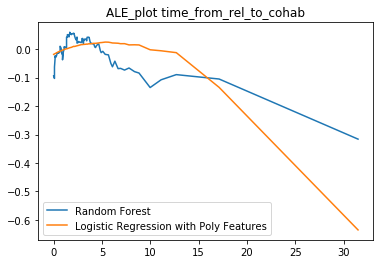

In [266]:
plt.plot(forest_ale_x, forest_ale_y)
plt.plot(log_reg_ale_x, log_reg_ale_y)

plt.title("ALE_plot time_from_rel_to_cohab")
plt.legend(['Random Forest', 'Logistic Regression with Poly Features'], loc='best')

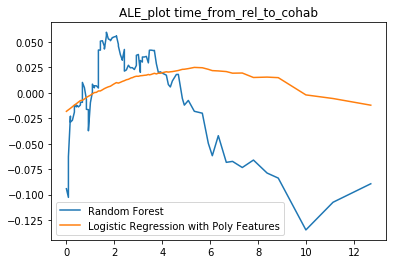

In [273]:
# ten sam wykres z pominięciem dwóch ostatnich punktów dla zmiejszenia skali na osiach i zwiększenia czytelności
plt.plot(forest_ale_x[:-2], forest_ale_y[:-2])
plt.plot(log_reg_ale_x[:-2], log_reg_ale_y[:-2])

plt.title("ALE_plot time_from_rel_to_cohab")
plt.legend(['Random Forest', 'Logistic Regression with Poly Features'], loc='best')

Jak widzimy regresja logistyczna (oparta na zmiennych wielomianowych stopnia 2) pokazuje kwadratową zależność zmiany odpowiedzi od zmiany (liniowej) parametru 'time_from_rel_to_cohab', co jest w pełni zgodne z charakterstyką modelu liniowego. patrząc konkretne wartości liczbowe na osi y widzimy również, że ten parametr w bardzo niewielkim stopniu wpływa na zmianę odpowiedzi modelu. Większy wpływ ta zmienna ma na model lasu losowego. Dodatkowo ALE plot nie jest płaski niemal na całej długości, więc nawet niewielka zmiana może zaburzyć odpowiedź modelu.